In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [2]:
# constants
NUM_STATES = 3
GAMMA = 0.9
NUM_ACTIONS = 2
WORLD_SIZE = 5
ACTIONS = [(1,0), (0,1), (-1,0), (0,-1)]

In [12]:
# gridworld implementation
class GridWorld:

    def __init__(self, A=(0,1), Ap=(4,1), Ar=10, B=(0,3), Bp=(2,3), Br=5):
        self.size = WORLD_SIZE
        self.A = A
        self.Ap = Ap
        self.Ar = Ar
        self.B = B
        self.Bp = Bp
        self.Br = Br

    def step(self, state, action):
        if state == self.A: return self.Ap, self.Ar
        if state == self.B: return self.Bp, self.Br
        s0, s1 = state
        a0, a1 = action
        x, y = s0 + a0, s1 + a1
        if x < 0 or y < 0 or x >= self.size or y >= self.size: return state, -1
        return (x, y), 0

In [4]:
# policy evaluation implementation
def policy_evaluation(policy, env):
    v = np.zeros((WORLD_SIZE, WORLD_SIZE))
    error = float('inf')
    while error > 1e-4:
        vp = np.zeros_like(v)
        for i in range(WORLD_SIZE):
            for j in range(WORLD_SIZE):
                for k, action in enumerate(ACTIONS):
                    (x, y), reward = env.step((i,j), action)
                    vp[i, j] += policy[i][j][k] * (reward + GAMMA * v[x, y])
        error = np.mean(np.abs(v - vp))
        v = vp
    return v

In [21]:
# generate data
policy = np.full((WORLD_SIZE, WORLD_SIZE, len(ACTIONS)), 1/len(ACTIONS))
env = GridWorld()
v = policy_evaluation(policy, env)

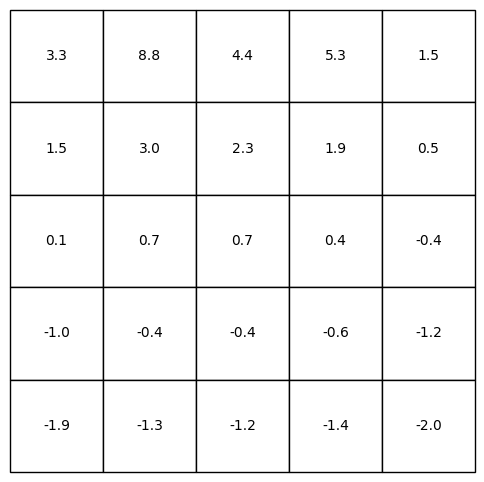

In [25]:
# generate figure 2.3

fig, ax = plt.subplots(figsize=(6, 6))

ax.set_axis_off()
tb = Table(ax)

for (i, j), val in np.ndenumerate(v):
    tb.add_cell(i, j, 0.2, 0.2, text=np.round(val, 1), loc='center')

ax.add_table(tb)

plt.show()

POLICY EVALUATION

In [3]:
# random distribution implementation
def create_distribution(n, temp=1.0):
    logits = np.random.randn(n)
    exp_logits = np.exp(logits / temp)
    prob = np.exp(logits) / exp_logits.sum()
    return prob

In [6]:
# mrp implementation
def create_mrp():
    P = np.zeros((NUM_STATES, NUM_STATES))
    for s in range(NUM_STATES):
        P[s, :] = create_distribution(NUM_STATES)
    r = np.random.randn(NUM_STATES, 1)
    return P, r

In [27]:
# policy evaluation implementation
def policy_eval(P, r, gamma):
    bellman_op = lambda v: r + gamma * P @ v
    v = np.random.randn(P.shape[0], 1)
    error = float('inf')
    while error > 1e-5:
        v0 = v
        v = bellman_op(v0)
        error = np.mean(np.abs(v - v0))
    return v

In [15]:
# verification
def compute_true_v(P, r, gamma):
    v = np.linalg.inv((np.eye(NUM_STATES) - gamma * P)) @ r
    return v

In [21]:
# run tests
P, r = create_mrp()
v = policy_eval(P, r, GAMMA)
true_v = compute_true_v(P, r, GAMMA)
print(v)
print(true_v)

[[-7.80351133]
 [-5.44894515]
 [-8.23066068]]
[[-7.80359411]
 [-5.44902793]
 [-8.23074346]]


POLICY ITERATION

In [23]:
# mdp implementation
def create_mdp():
    P = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES))
    for s in range(NUM_STATES):
        for a in range(NUM_ACTIONS):
            P[s, a, :] = create_distribution(NUM_STATES)
    r = np.random.randn(NUM_STATES, NUM_ACTIONS)
    return P, r

In [29]:
# policy iteration implementation
def init_policy():
    pi = np.zeros((NUM_STATES, NUM_ACTIONS))
    for s in range(NUM_STATES):
        pi[s, :] = create_distribution(NUM_ACTIONS)
    return pi

def policy_iter(P, r, gamma):
    pi = init_policy()
    r = np.reshape(r, (NUM_STATES * NUM_ACTIONS, 1))
    # error = float('inf')
    while True:
        P_pi = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES, NUM_ACTIONS))
        for s in range(NUM_STATES):
            for a in range(NUM_ACTIONS):
                for s_prime in range(NUM_STATES):
                    for a_prime in range(NUM_ACTIONS):
                        P_pi[s, a, s_prime, a_prime] = P[s, a, s_prime] * pi[s_prime, a_prime]
        P_pi = np.reshape(P_pi, (NUM_STATES * NUM_ACTIONS, NUM_STATES * NUM_ACTIONS))
        q = policy_eval(P_pi, r, gamma)
        print(q)
        q = np.reshape(q, (NUM_STATES, NUM_ACTIONS))
        pi = np.zeros((NUM_STATES, NUM_ACTIONS))
        for s in range(NUM_STATES):
            pi[s, np.argmax(q[s, :])] = 1
        # error = np.mean(np.abs(q - q0))
        # q0 = q
        

In [30]:
# run tests
P, r = create_mdp()
policy_iter(P, r, GAMMA)


[[2.84713084]
 [1.64059437]
 [2.46018006]
 [4.16059807]
 [2.40353974]
 [3.70897253]]
[[10.13072052]
 [ 8.9529809 ]
 [ 9.64320543]
 [11.41441333]
 [ 9.48522552]
 [11.01371188]]
[[10.13072361]
 [ 8.952984  ]
 [ 9.64320853]
 [11.41441643]
 [ 9.48522862]
 [11.01371497]]
[[10.13072438]
 [ 8.95298476]
 [ 9.6432093 ]
 [11.41441719]
 [ 9.48522939]
 [11.01371574]]
[[10.13072774]
 [ 8.95298813]
 [ 9.64321266]
 [11.41442056]
 [ 9.48523275]
 [11.0137191 ]]
[[10.13072283]
 [ 8.95298321]
 [ 9.64320775]
 [11.41441564]
 [ 9.48522783]
 [11.01371419]]
[[10.13072172]
 [ 8.9529821 ]
 [ 9.64320663]
 [11.41441453]
 [ 9.48522672]
 [11.01371308]]
[[10.13072858]
 [ 8.95298896]
 [ 9.64321349]
 [11.41442139]
 [ 9.48523358]
 [11.01371993]]
[[10.13072547]
 [ 8.95298585]
 [ 9.64321039]
 [11.41441829]
 [ 9.48523048]
 [11.01371683]]
[[10.13072244]
 [ 8.95298283]
 [ 9.64320736]
 [11.41441526]
 [ 9.48522745]
 [11.0137138 ]]
[[10.13072631]
 [ 8.95298669]
 [ 9.64321123]
 [11.41441912]
 [ 9.48523131]
 [11.01371767]]
[[10.

KeyboardInterrupt: 

VALUE ITERATION

In [36]:
# bellman optimality implementation
def bellman_optimality_op_factory(P, r, gamma):
    def bellman_optimality_op(v):
        new_v = np.zeros_like(v)
        for s in range(NUM_STATES):
            for a in range(NUM_ACTIONS):
                q_sa = r(s, a) + gamma * np.sum([P[s, a, s_prime] * v(s_prime) for s_prime in range(NUM_STATES)])
            new_v[s] = np.max(q_sa)
        return new_v
    return bellman_optimality_op
                

In [32]:
def value_iter(P, r, gamma):
    bellman_op = bellman_optimality_op_factory(P, r, gamma)
    v = np.random.randn(P.shape[0], 1)
    error = float('inf')
    while error > 1e-5:
        v0 = v
        v = bellman_op(v0)
        error = np.mean(np.abs(v - v0))
    return v

In [37]:
P, r = create_mdp()
v = value_iter(P, r, GAMMA)
print(v)

TypeError: 'numpy.ndarray' object is not callable